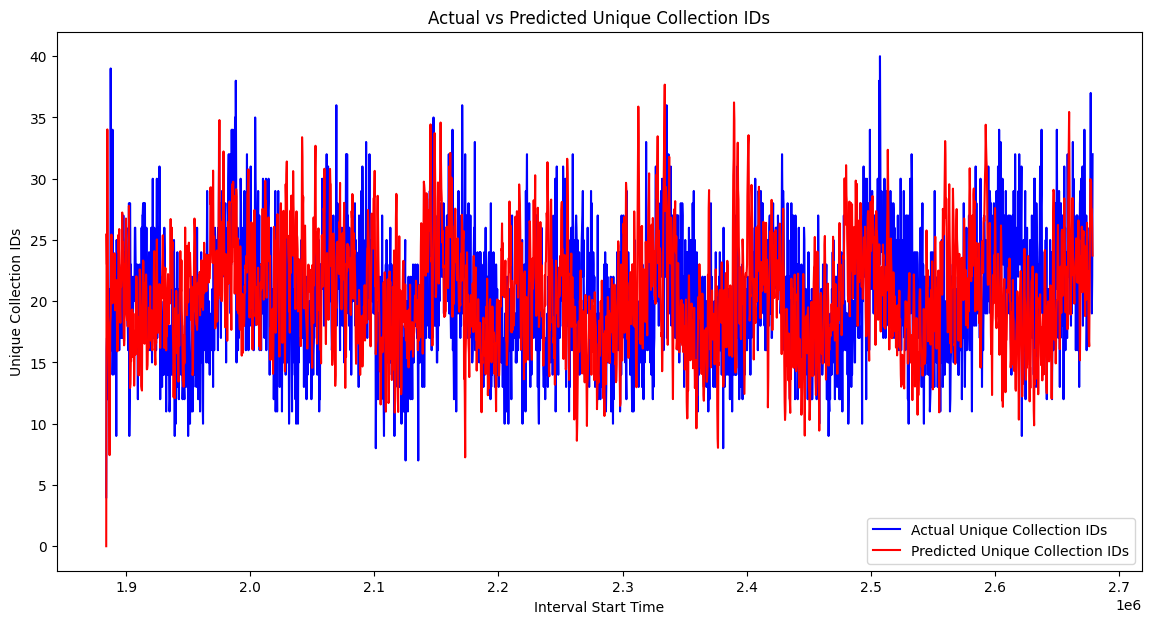

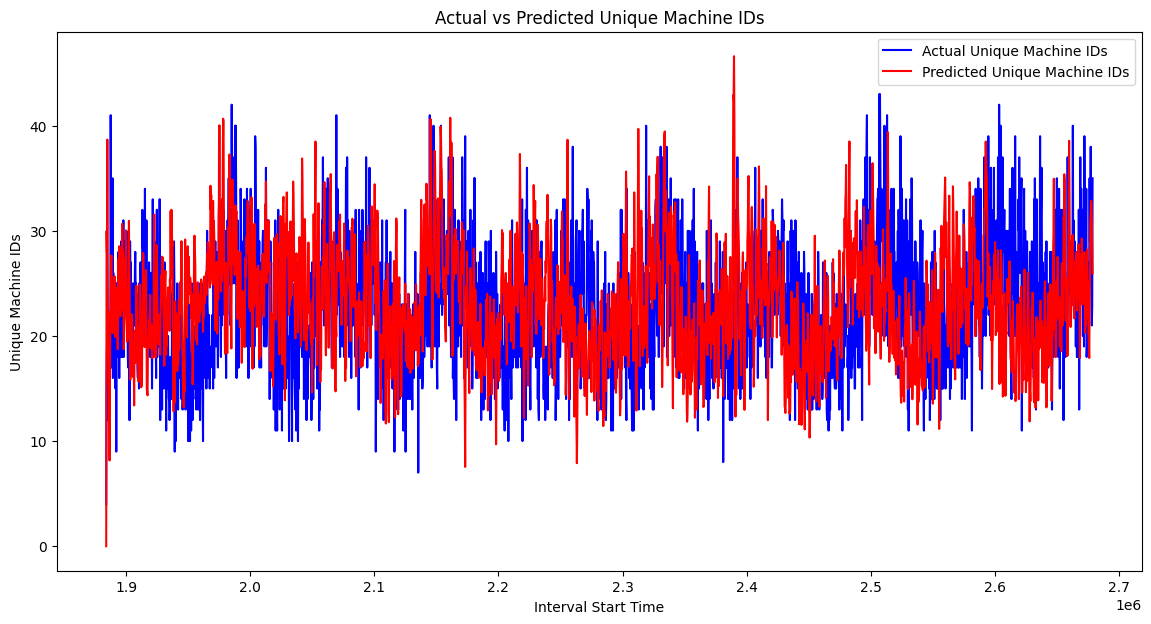

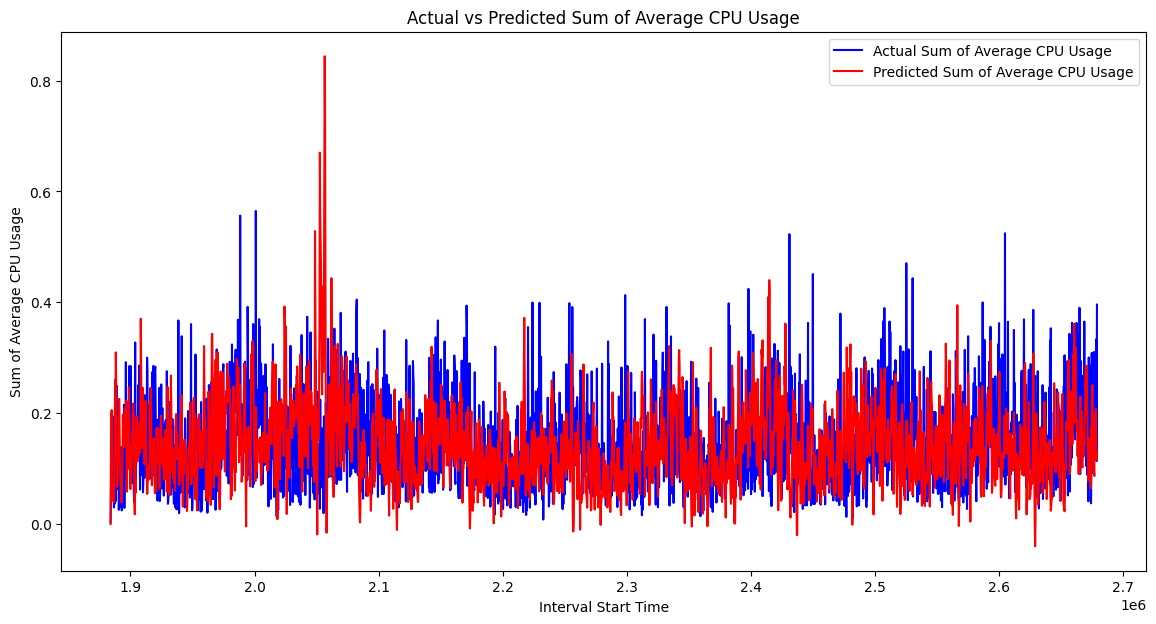

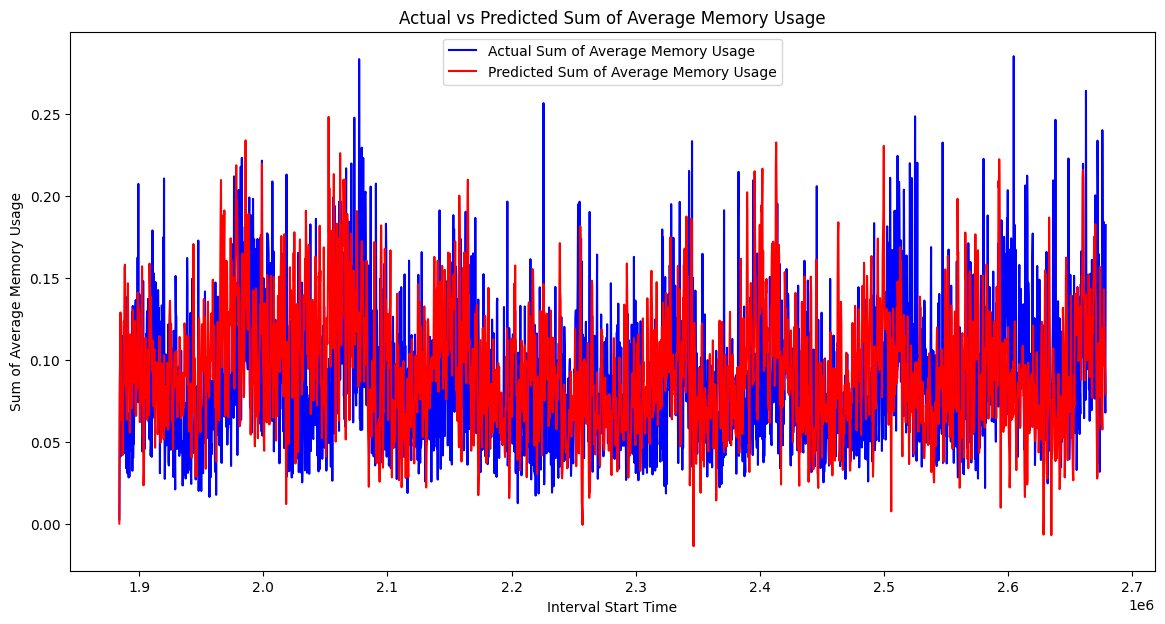

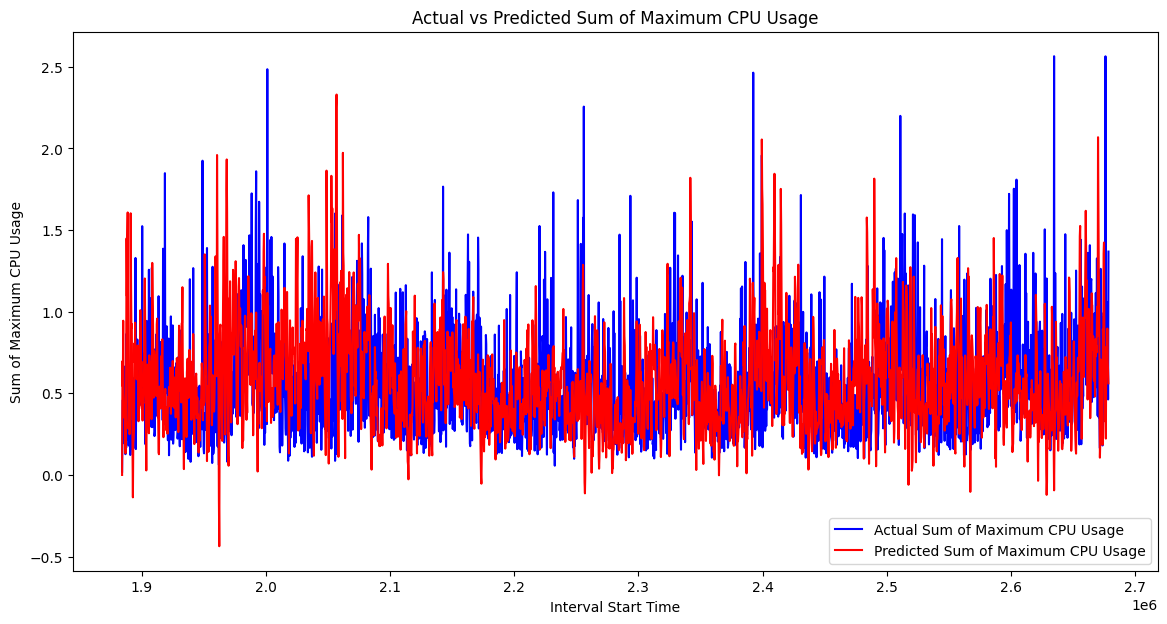

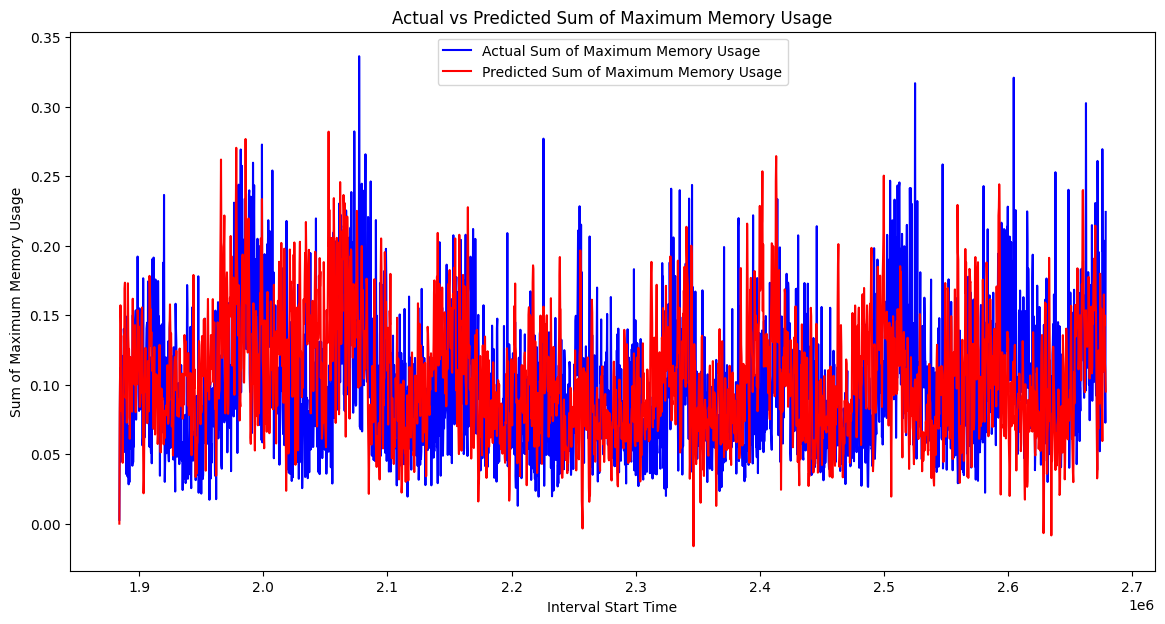

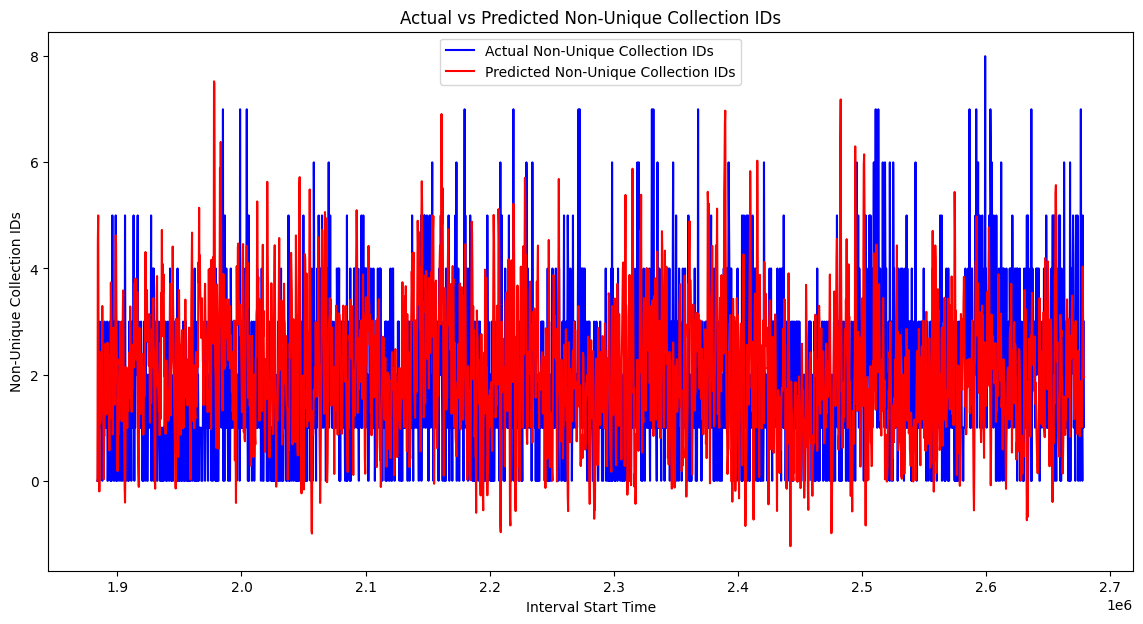

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()
    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def create_interval_features(df):
    start_time = df['start_time'].min()
    end_time = df['start_time'].max()
    current_start = start_time
    results = []
    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = df[(df['start_time'] >= current_start) & (df['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start
            interval_result['interval_end'] = current_end
            results.append(interval_result)
        current_start = current_end
    return pd.DataFrame(results)

# Split data into training (70%) and testing (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

# Process training data
train_intervals_df = create_interval_features(train_data)

# Prepare the target variables for ARIMA models
train_targets = {
    'unique_collection_ids': train_intervals_df['unique_collection_ids'],
    'unique_machine_ids': train_intervals_df['unique_machine_ids'],
    'sum_avg_cpu': train_intervals_df['sum_avg_cpu'],
    'sum_avg_memory': train_intervals_df['sum_avg_memory'],
    'sum_max_cpu': train_intervals_df['sum_max_cpu'],
    'sum_max_memory': train_intervals_df['sum_max_memory'],
    'non_unique_collection_ids': train_intervals_df['non_unique_collection_ids']
}

# Train ARIMA models for each target variable
models = {}
for target in train_targets:
    models[target] = ARIMA(train_targets[target], order=(5,2,0)).fit()

# Process the testing data into intervals
test_intervals_df = create_interval_features(test_data)

# Prepare the actual values(ground truth)
actual_values = {
    'unique_collection_ids': test_intervals_df['unique_collection_ids'],
    'unique_machine_ids': test_intervals_df['unique_machine_ids'],
    'sum_avg_cpu': test_intervals_df['sum_avg_cpu'],
    'sum_avg_memory': test_intervals_df['sum_avg_memory'],
    'sum_max_cpu': test_intervals_df['sum_max_cpu'],
    'sum_max_memory': test_intervals_df['sum_max_memory'],
    'non_unique_collection_ids': test_intervals_df['non_unique_collection_ids']
}

# Make predictions 
predictions = {}
for target in actual_values:
    predictions[target] = models[target].predict(start=0, end=len(test_intervals_df)-1)

# Add actual and predicted values to test intervals DataFrame
for target in actual_values:
    test_intervals_df[f'predicted_{target}'] = predictions[target]
    test_intervals_df[f'actual_{target}'] = actual_values[target]

# Plotting function
def plot_actual_vs_predicted(df, target, ylabel, title):
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='interval_start', y=f'actual_{target}', data=df, label=f'Actual {ylabel}', color='blue')
    sns.lineplot(x='interval_start', y=f'predicted_{target}', data=df, label=f'Predicted {ylabel}', color='red')
    plt.xlabel('Interval Start Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Actual vs Predicted for each target variable
plot_actual_vs_predicted(test_intervals_df, 'unique_collection_ids', 'Unique Collection IDs', 'Actual vs Predicted Unique Collection IDs')
plot_actual_vs_predicted(test_intervals_df, 'unique_machine_ids', 'Unique Machine IDs', 'Actual vs Predicted Unique Machine IDs')
plot_actual_vs_predicted(test_intervals_df, 'sum_avg_cpu', 'Sum of Average CPU Usage', 'Actual vs Predicted Sum of Average CPU Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_avg_memory', 'Sum of Average Memory Usage', 'Actual vs Predicted Sum of Average Memory Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_max_cpu', 'Sum of Maximum CPU Usage', 'Actual vs Predicted Sum of Maximum CPU Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_max_memory', 'Sum of Maximum Memory Usage', 'Actual vs Predicted Sum of Maximum Memory Usage')
plot_actual_vs_predicted(test_intervals_df, 'non_unique_collection_ids', 'Non-Unique Collection IDs', 'Actual vs Predicted Non-Unique Collection IDs')

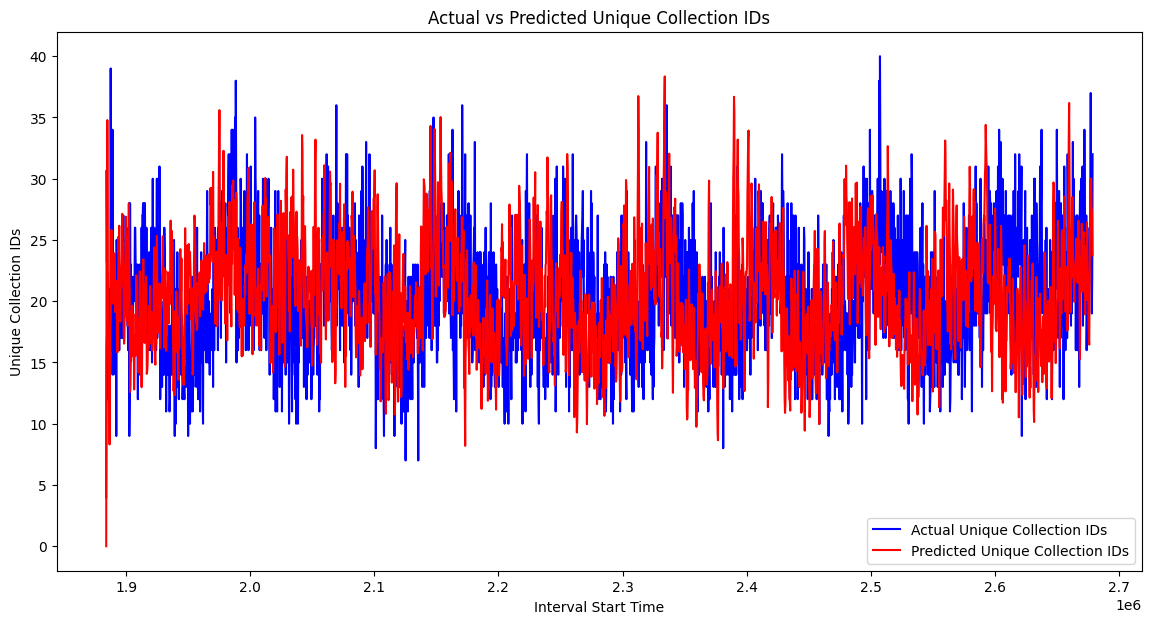

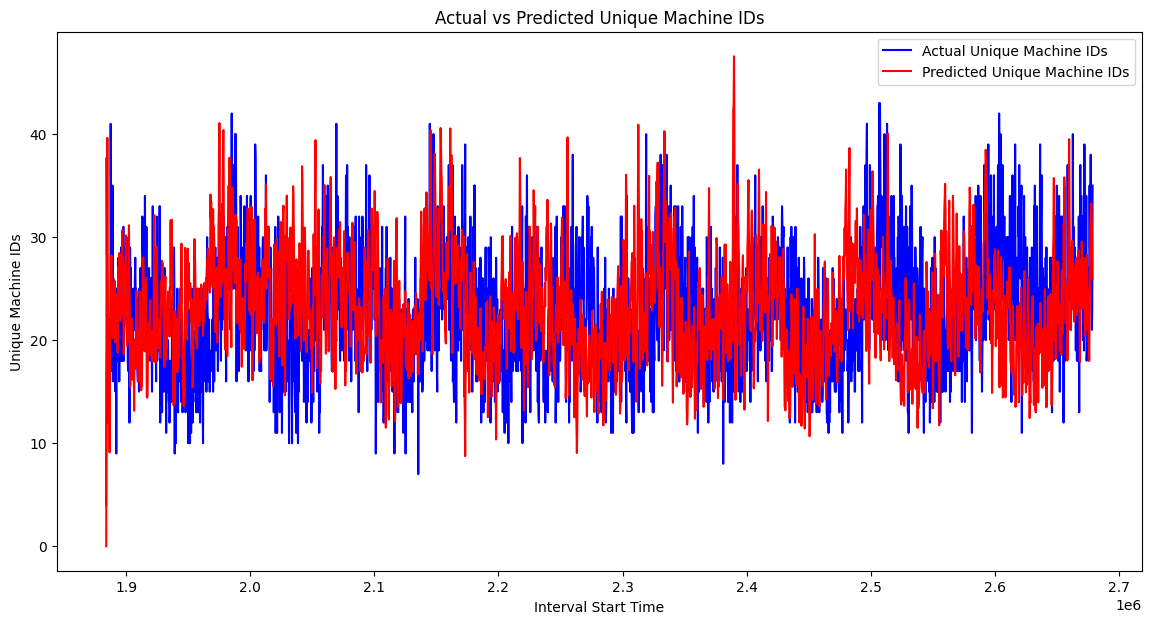

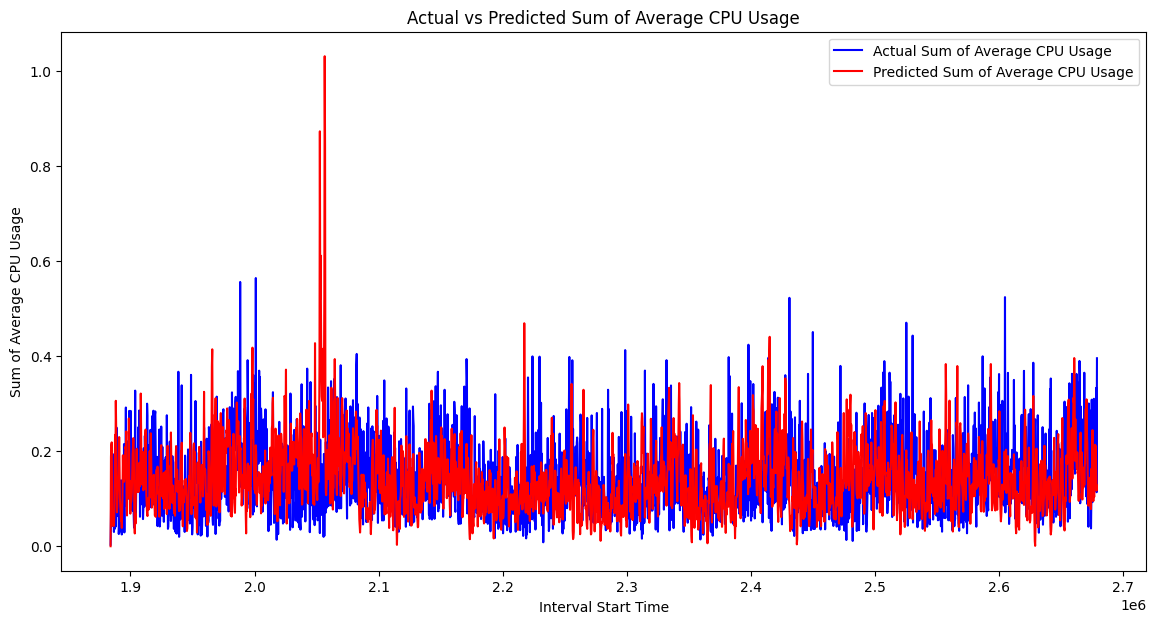

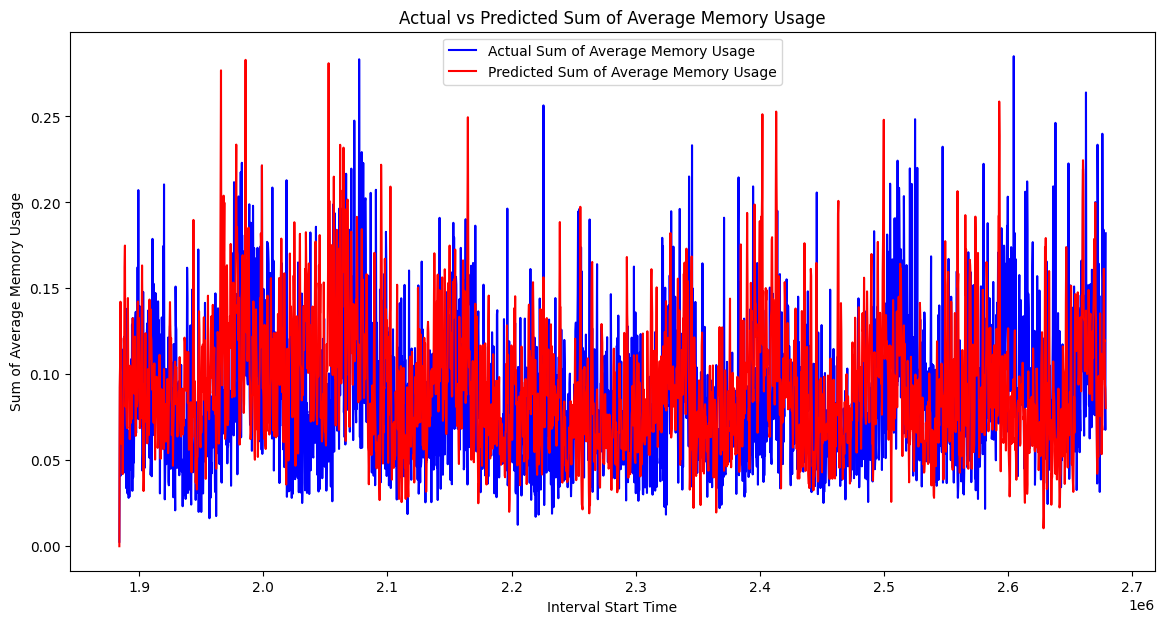

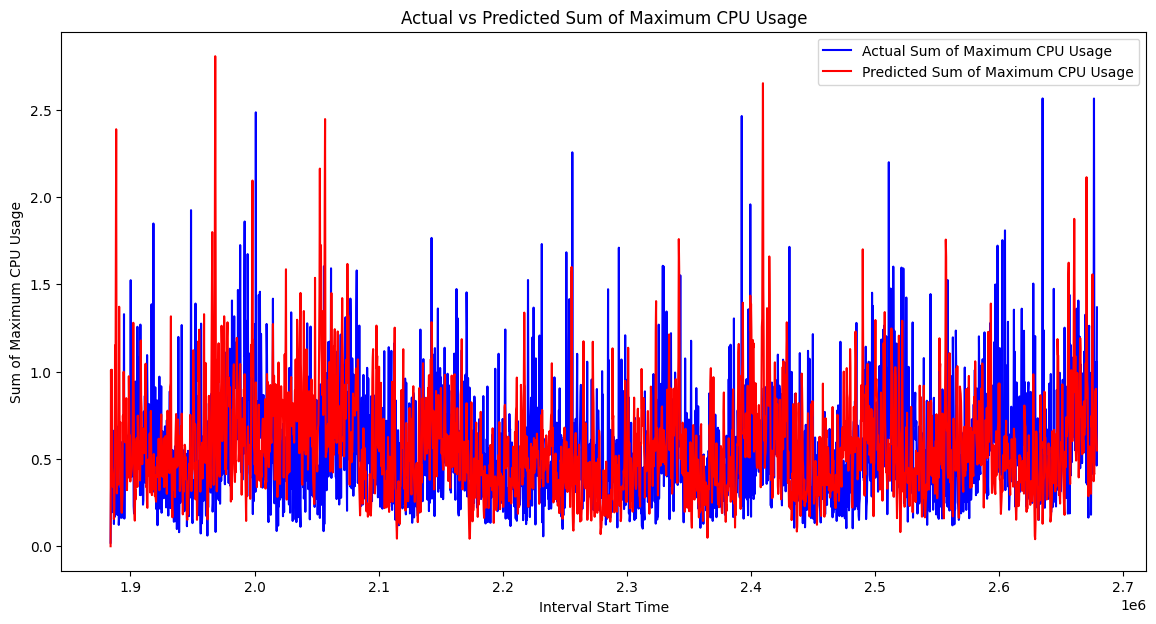

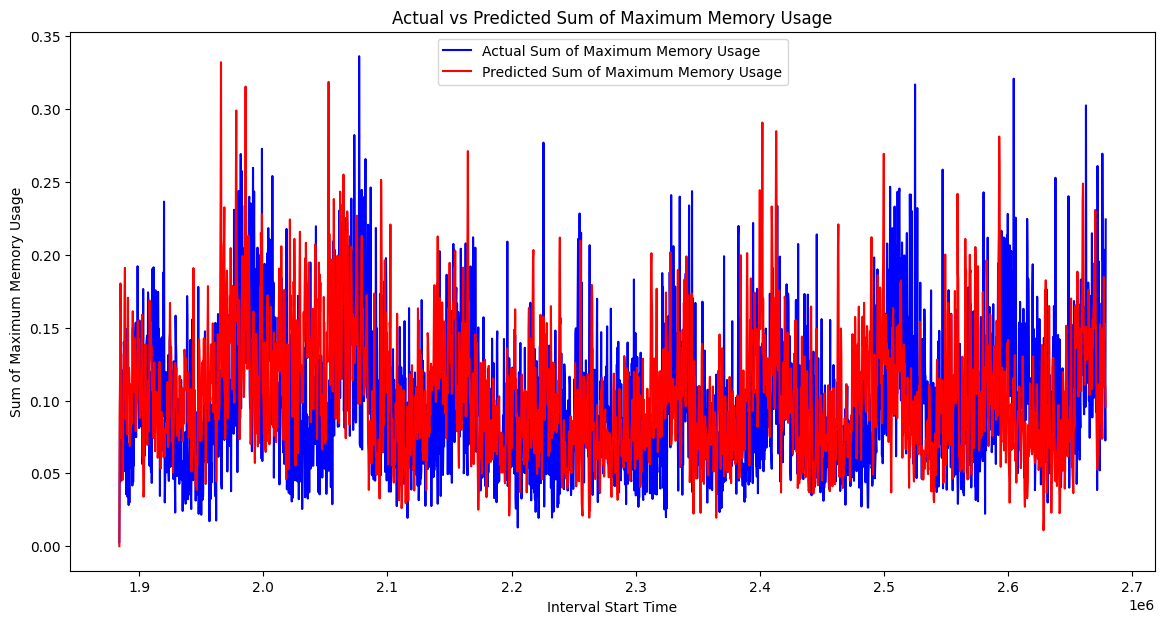

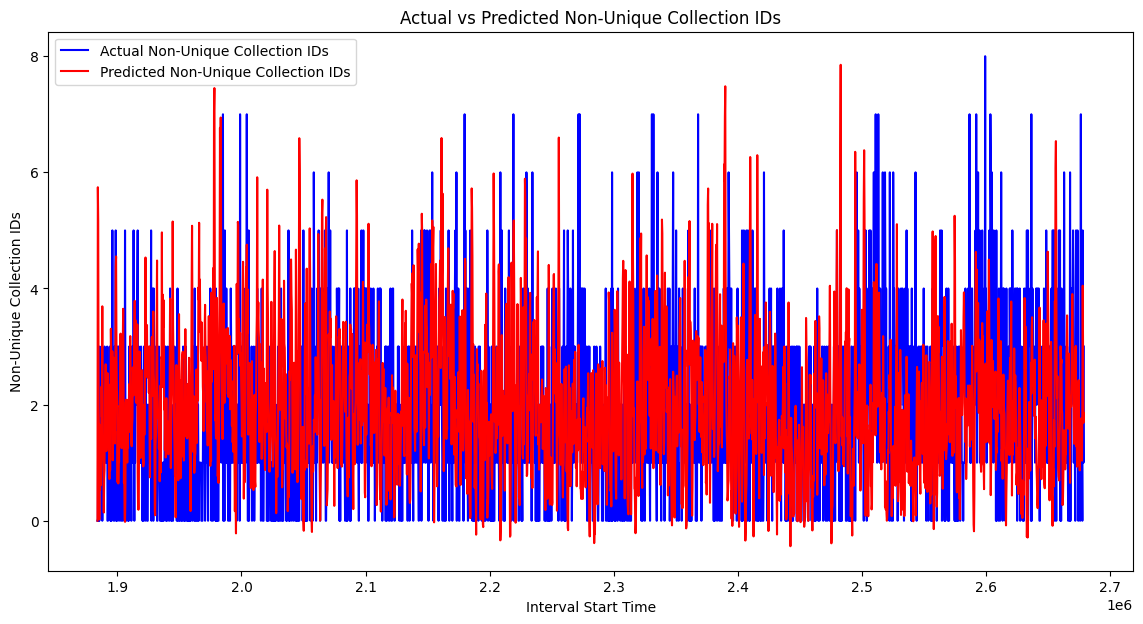

In [3]:
from scipy import stats
import numpy as np

# Apply Box-Cox transformation to stablizize the variance
train_targets_boxcox = {}
test_targets_boxcox = {}
lambdas = {}

for target in train_targets:
    train_targets_boxcox[target], lambdas[target] = stats.boxcox(train_targets[target] + 1)
    test_targets_boxcox[target] = stats.boxcox(actual_values[target] + 1, lmbda=lambdas[target])

models_boxcox = {}
for target in train_targets_boxcox:
    models_boxcox[target] = ARIMA(train_targets_boxcox[target], order=(5, 2, 0)).fit()

# Make predictions on the test data (using Box-Cox transformed data)
predictions_boxcox = {}
for target in test_targets_boxcox:
    predictions_boxcox[target] = models_boxcox[target].predict(start=0, end=len(test_intervals_df)-1)

#  inverse Box-Cox transformation
def inv_boxcox(y, lmbda):
    if lmbda != 0:
        return np.exp(np.log(y * lmbda + 1) / lmbda) - 1
    else:
        return np.exp(y) - 1

# Convert the predictions back to the original scale
predictions_original_scale = {}
for target in predictions_boxcox:
    predictions_original_scale[target] = inv_boxcox(predictions_boxcox[target], lambdas[target])

# Add predictions to test_intervals_df for comparison
for target in predictions_original_scale:
    test_intervals_df[f'predicted_{target}'] = predictions_original_scale[target]
    test_intervals_df[f'actual_{target}'] = actual_values[target]

# Plot Actual vs Predicted for each target variable on the original scale
plot_actual_vs_predicted(test_intervals_df, 'unique_collection_ids', 'Unique Collection IDs', 'Actual vs Predicted Unique Collection IDs')
plot_actual_vs_predicted(test_intervals_df, 'unique_machine_ids', 'Unique Machine IDs', 'Actual vs Predicted Unique Machine IDs')
plot_actual_vs_predicted(test_intervals_df, 'sum_avg_cpu', 'Sum of Average CPU Usage', 'Actual vs Predicted Sum of Average CPU Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_avg_memory', 'Sum of Average Memory Usage', 'Actual vs Predicted Sum of Average Memory Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_max_cpu', 'Sum of Maximum CPU Usage', 'Actual vs Predicted Sum of Maximum CPU Usage')
plot_actual_vs_predicted(test_intervals_df, 'sum_max_memory', 'Sum of Maximum Memory Usage', 'Actual vs Predicted Sum of Maximum Memory Usage')
plot_actual_vs_predicted(test_intervals_df, 'non_unique_collection_ids', 'Non-Unique Collection IDs', 'Actual vs Predicted Non-Unique Collection IDs')


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return mse, rmse, mae, mape

metrics = {}
for target in predictions_original_scale:
    mse, rmse, mae, mape = calculate_metrics(test_intervals_df[f'actual_{target}'], test_intervals_df[f'predicted_{target}'])
    metrics[target] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

for target in metrics:
    print(f"Metrics for {target}:")
    print(f"  MSE: {metrics[target]['MSE']}")
    print(f"  RMSE: {metrics[target]['RMSE']}")
    print(f"  MAE: {metrics[target]['MAE']}")
    print(f"  MAPE: {metrics[target]['MAPE']}%\n")


Metrics for unique_collection_ids:
  MSE: 39.28376468894963
  RMSE: 6.267676179330712
  MAE: 5.029177378578553
  MAPE: 26.52762722185063%

Metrics for unique_machine_ids:
  MSE: 55.776368978525994
  RMSE: 7.468357850192102
  MAE: 5.980359746491197
  MAPE: 28.707439849146567%

Metrics for sum_avg_cpu:
  MSE: 0.010634593336439199
  RMSE: 0.10312416465814013
  MAE: 0.07694958368857255
  MAPE: 74.2100820990532%

Metrics for sum_avg_memory:
  MSE: 0.00277925987383687
  RMSE: 0.052718686192249425
  MAE: 0.040839170914597815
  MAPE: 58.65815550015194%

Metrics for sum_max_cpu:
  MSE: 0.16637262154303642
  RMSE: 0.4078880012246455
  MAE: 0.30249194378308475
  MAPE: 71.47962255632521%

Metrics for sum_max_memory:
  MSE: 0.0036084525455438196
  RMSE: 0.060070396582208606
  MAE: 0.04642877447022006
  MAPE: 59.44643491320088%

Metrics for non_unique_collection_ids:
  MSE: 3.6104595139205293
  RMSE: 1.9001209208680718
  MAE: 1.481631149822961
  MAPE: inf%

